/tmp/ipykernel_174/2720220390.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=mutations_df, x="Chromosome", palette="viridis")


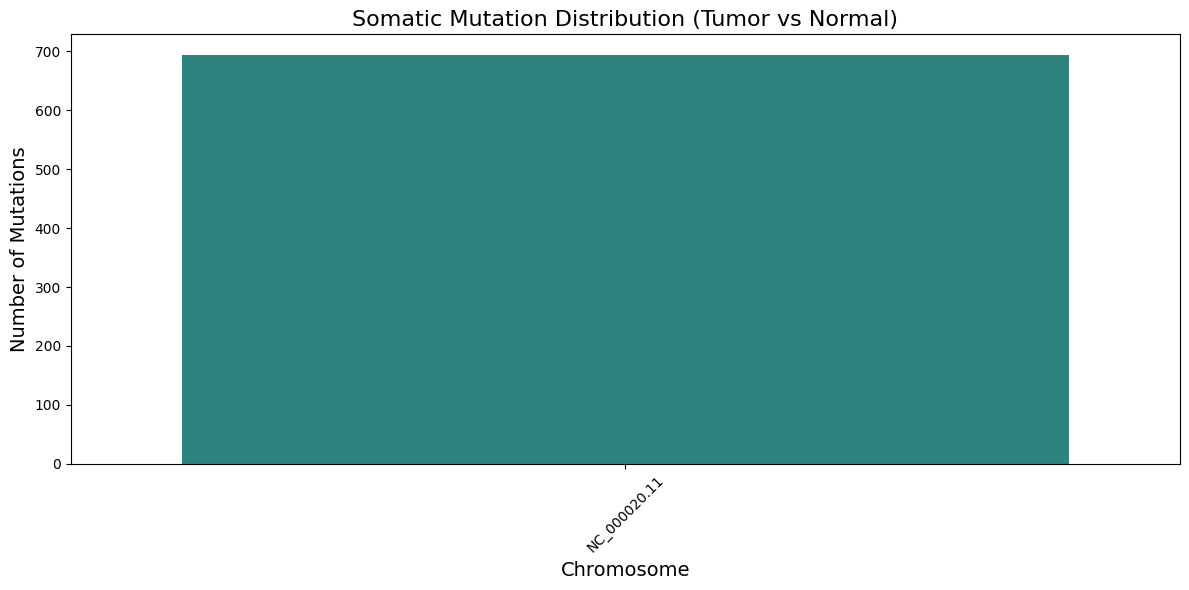

In [4]:
#load the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pysam import VariantFile
import gzip

# Load the somatic mutations VCF file (output from bcftools isec)
vcf_file = "output_dir/0000.vcf"

# Parse VCF file
def parse_vcf(vcf_file):
    mutations = []
    with open(vcf_file, "r") as f:
        for line in f:
            if line.startswith("#"):  # Skip header lines
                continue
            columns = line.strip().split("\t")
            chrom = columns[0]
            pos = columns[1]
            ref = columns[3]
            alt = columns[4]
            qual = columns[5]
            mutations.append([chrom, pos, ref, alt, qual])
    
    # Create DataFrame
    df = pd.DataFrame(mutations, columns=["Chromosome", "Position", "Ref", "Alt", "Quality"])
    return df

# Create plot of mutation distribution
def plot_mutation_distribution(mutations_df):
    # Create a plot of mutation distribution across chromosomes
    plt.figure(figsize=(12, 6))
    sns.countplot(data=mutations_df, x="Chromosome", palette="viridis")
    plt.title("Somatic Mutation Distribution (Tumor vs Normal)", fontsize=16)
    plt.xlabel("Chromosome", fontsize=14)
    plt.ylabel("Number of Mutations", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Parse VCF file and plot
mutations_df = parse_vcf(vcf_file)
plot_mutation_distribution(mutations_df)


In [5]:
# Input VCF files for tumor and normal (gzipped)
normal_vcf = "normal_variants.vcf.gz"
tumor_vcf = "tumor_variants.vcf.gz"

# Parse VCF file and extract mutations (handle gzipped files)
def parse_vcf(vcf_file):
    mutations = []
    
    with gzip.open(vcf_file, "rt") as f:  # Open gzipped file in text mode
        for line in f:
            if line.startswith("#"):  # Skip header lines
                continue
            columns = line.strip().split("\t")
            chrom = columns[0]
            pos = columns[1]
            ref = columns[3]
            alt = columns[4]
            qual = columns[5]
            mutations.append([chrom, pos, ref, alt, qual])
    
    # Create DataFrame
    df = pd.DataFrame(mutations, columns=["Chromosome", "Position", "Ref", "Alt", "Quality"])
    return df

# Parse both tumor and normal VCF files
normal_mutations_df = parse_vcf(normal_vcf)
tumor_mutations_df = parse_vcf(tumor_vcf)

# Display the first few rows of both mutation dataframes
print("Normal Tissue Mutations:")
print(normal_mutations_df.head())
print("\nTumor Tissue Mutations:")
print(tumor_mutations_df.head())


Normal Tissue Mutations:
     Chromosome Position Ref Alt  Quality
0  NC_000020.11   159756   T   C  16.5123
1  NC_000020.11   305197   T   C  17.4819
2  NC_000020.11   305205   G   A       73
3  NC_000020.11   305210   G   A  15.3401
4  NC_000020.11  1403864   G   A  18.4764

Tumor Tissue Mutations:
     Chromosome Position Ref    Alt  Quality
0  NC_000020.11    62469   G      A  8.13869
1  NC_000020.11   305185  AG  AGAGG   23.434
2  NC_000020.11   305197   T      C      195
3  NC_000020.11   305205   G      A      198
4  NC_000020.11   305244   C      A       78


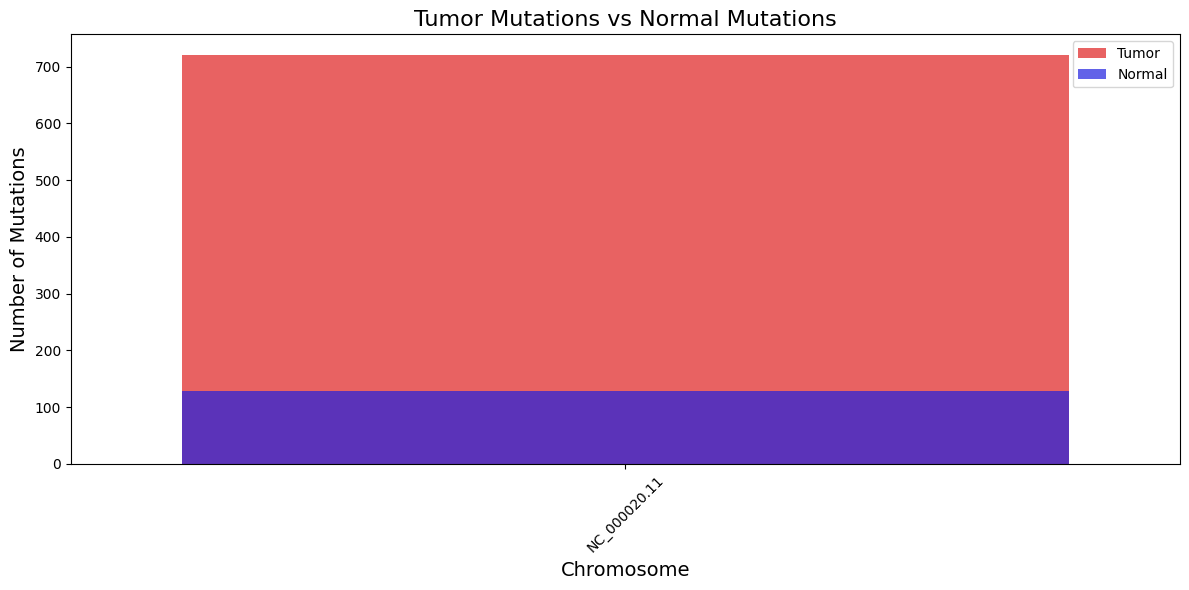

In [6]:
# Count mutations per chromosome for tumor and normal
tumor_mut_counts = tumor_mutations_df['Chromosome'].value_counts()
normal_mut_counts = normal_mutations_df['Chromosome'].value_counts()

# Merge the mutation counts
mutation_counts_df = pd.DataFrame({
    "Chromosome": tumor_mut_counts.index,
    "Tumor_Mutations": tumor_mut_counts.values,
    "Normal_Mutations": normal_mut_counts.reindex(tumor_mut_counts.index, fill_value=0).values
})

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the mutations for tumor vs normal
sns.barplot(data=mutation_counts_df, x="Chromosome", y="Tumor_Mutations", color="red", alpha=0.7, label="Tumor")
sns.barplot(data=mutation_counts_df, x="Chromosome", y="Normal_Mutations", color="blue", alpha=0.7, label="Normal")

# Customize plot
plt.title("Tumor Mutations vs Normal Mutations", fontsize=16)
plt.xlabel("Chromosome", fontsize=14)
plt.ylabel("Number of Mutations", fontsize=14)
plt.xticks(rotation=45)
plt.legend()

# Display plot
plt.tight_layout()
plt.show()


In [7]:
# Identify somatic mutations (mutations present in tumor but absent in normal)
def identify_somatic_mutations(normal_df, tumor_df):
    # Merge the dataframes on chromosome and position
    merged_df = pd.merge(tumor_df, normal_df, on=["Chromosome", "Position", "Ref", "Alt"], how="left", indicator=True)

    # Somatic mutations are present in tumor (right) but not in normal (left)
    somatic_mutations_df = merged_df[merged_df["_merge"] == "left_only"]

    return somatic_mutations_df

# Identify somatic mutations in tumor vs normal
somatic_mutations_df = identify_somatic_mutations(normal_mutations_df, tumor_mutations_df)

# Display somatic mutations
print("\nSomatic Mutations (Tumor-specific):")
print(somatic_mutations_df)



Somatic Mutations (Tumor-specific):
       Chromosome  Position Ref    Alt Quality_x Quality_y     _merge
0    NC_000020.11     62469   G      A   8.13869       NaN  left_only
1    NC_000020.11    305185  AG  AGAGG    23.434       NaN  left_only
4    NC_000020.11    305244   C      A        78       NaN  left_only
5    NC_000020.11    305267   G      T   22.4391       NaN  left_only
6    NC_000020.11    529027   G      T   5.04598       NaN  left_only
..            ...       ...  ..    ...       ...       ...        ...
716  NC_000020.11  64288791   C      T   21.4353       NaN  left_only
717  NC_000020.11  64288792   G      A   21.4353       NaN  left_only
718  NC_000020.11  64288810   G      C        67       NaN  left_only
719  NC_000020.11  64288814   T      C        67       NaN  left_only
720  NC_000020.11  64292839   T      A        80       NaN  left_only

[694 rows x 7 columns]


Total Somatic Mutations: 694
High-Quality Mutations (QUAL >= 30): 133
Mutations per Chromosome:
Chromosome
NC_000020.11    694
Name: count, dtype: int64


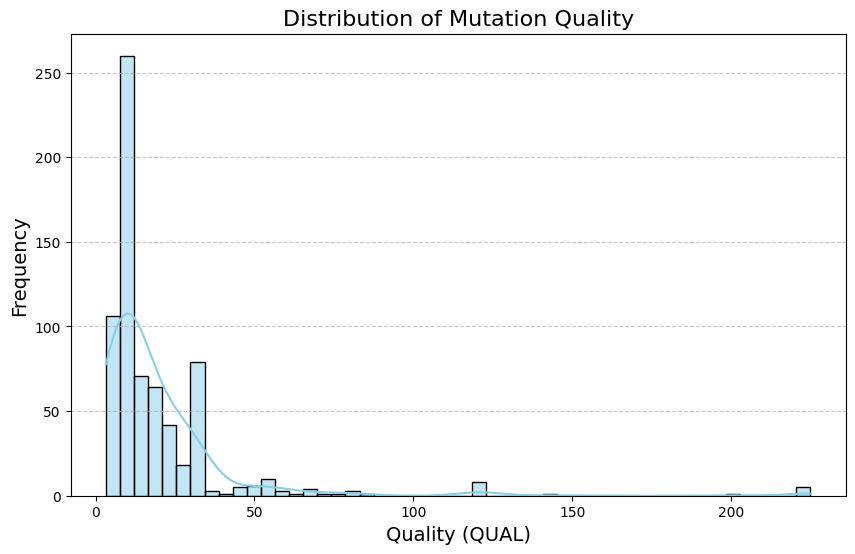

/tmp/ipykernel_174/1152111392.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


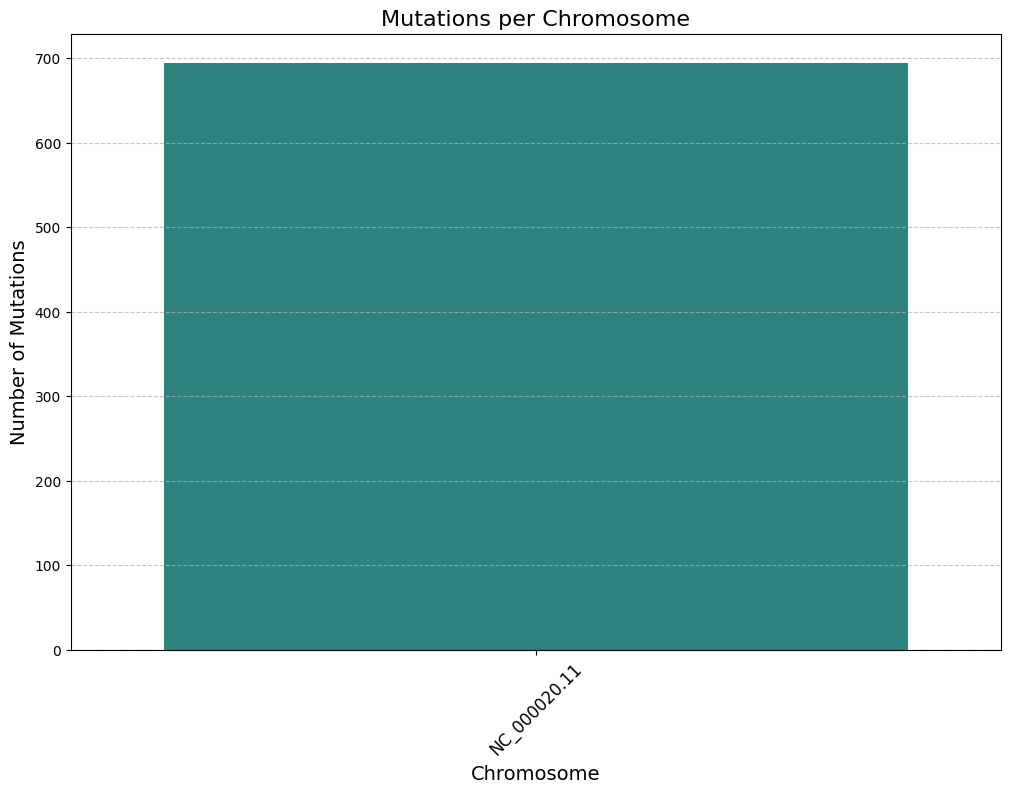

In [16]:
# Calculate metrics
def calculate_metrics(mutations_df):
    total_mutations = len(mutations_df)
    high_quality = mutations_df[mutations_df["Quality"] >= 30].shape[0]
    mut_per_chromosome = mutations_df["Chromosome"].value_counts()
    return total_mutations, high_quality, mut_per_chromosome

# Plot mutation distribution
def plot_mutations(mutations_df, mut_per_chromosome):
    # Quality distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(mutations_df["Quality"], bins=50, kde=True, color="skyblue")
    plt.title("Distribution of Mutation Quality", fontsize=16)
    plt.xlabel("Quality (QUAL)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Mutations per chromosome
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=mut_per_chromosome.index,
        y=mut_per_chromosome.values,
        palette="viridis"
    )
    plt.title("Mutations per Chromosome", fontsize=16)
    plt.xlabel("Chromosome", fontsize=14)
    plt.ylabel("Number of Mutations", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Process VCF file and calculate metrics
mutations_df = parse_vcf(vcf_file)
total_mutations, high_quality, mut_per_chromosome = calculate_metrics(mutations_df)

# Print results
print("Total Somatic Mutations:", total_mutations)
print("High-Quality Mutations (QUAL >= 30):", high_quality)
print("Mutations per Chromosome:")
print(mut_per_chromosome)

# Plot the results
plot_mutations(mutations_df, mut_per_chromosome)


[E::idx_find_and_load] Could not retrieve index file for 'tumor_calls.vcf'
[E::idx_find_and_load] Could not retrieve index file for 'norma_calls.vcf'


Total Tumor-Specific Mutations: 694
     Chromosome  Position Ref    Alt  Quality_x  Quality_y
0  NC_000020.11     62469   G      A   8.138687        NaN
1  NC_000020.11    305185  AG  AGAGG  23.433968        NaN
4  NC_000020.11    305244   C      A  78.000000        NaN
5  NC_000020.11    305267   G      T  22.439079        NaN
6  NC_000020.11    529027   G      T   5.045980        NaN


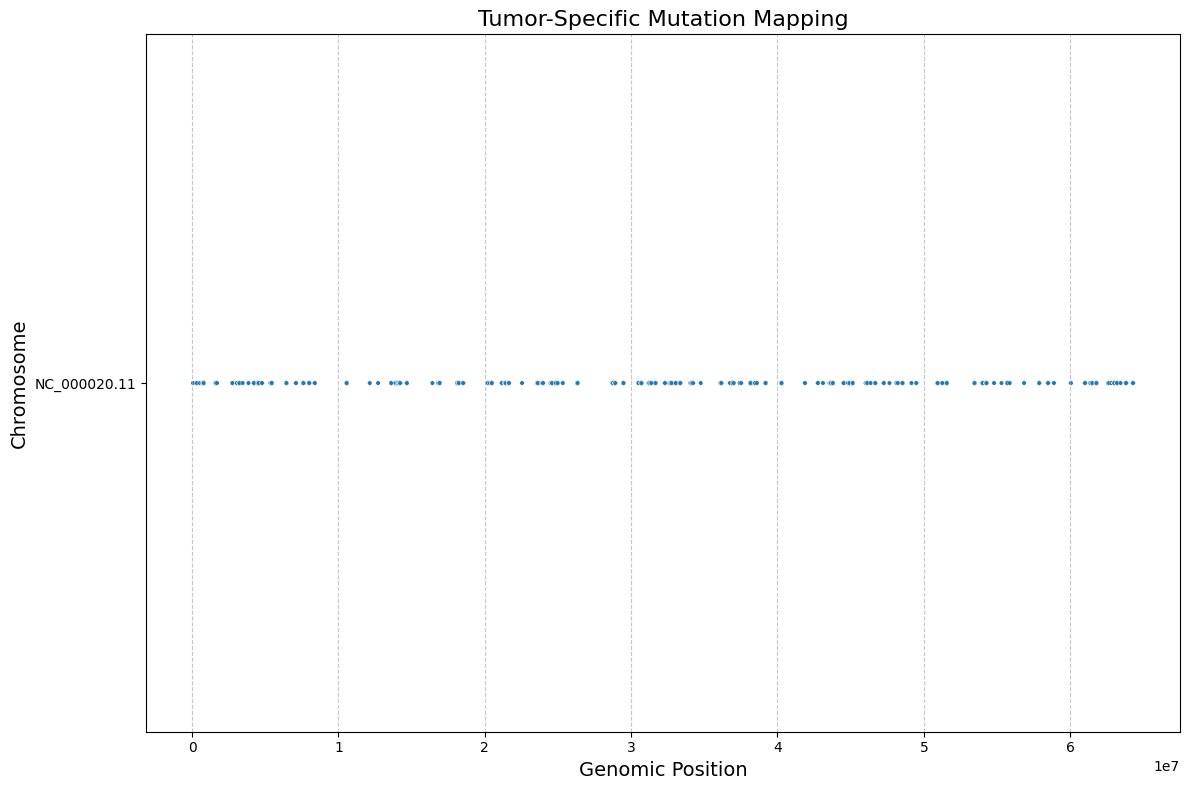

In [17]:
# Identify tumor-specific mutations
def identify_tumor_specific(tumor_df, normal_df):
    # Merge on Chromosome, Position, Ref, and Alt to find common mutations
    merged = pd.merge(tumor_df, normal_df, how="left", on=["Chromosome", "Position", "Ref", "Alt"], indicator=True)
    tumor_specific = merged[merged["_merge"] == "left_only"].drop(columns=["_merge"])
    return tumor_specific

# Plot mutation mapping
def plot_mutation_mapping(tumor_specific_df):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=tumor_specific_df,
        x="Position",
        y="Chromosome",
        hue="Chromosome",
        palette="tab20",
        s=10,
        legend=False
    )
    plt.title("Tumor-Specific Mutation Mapping", fontsize=16)
    plt.xlabel("Genomic Position", fontsize=14)
    plt.ylabel("Chromosome", fontsize=14)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Process VCF files
tumor_df = parse_vcf(tumor_vcf_file)
normal_df = parse_vcf(normal_vcf_file)

# Identify tumor-specific mutations
tumor_specific_df = identify_tumor_specific(tumor_df, normal_df)

# Print tumor-specific mutation stats
print("Total Tumor-Specific Mutations:", len(tumor_specific_df))
print(tumor_specific_df.head())

# Plot tumor-specific mutation mapping
plot_mutation_mapping(tumor_specific_df)



[E::idx_find_and_load] Could not retrieve index file for 'tumor_calls.vcf'
[E::idx_find_and_load] Could not retrieve index file for 'norma_calls.vcf'
/tmp/ipykernel_174/3772919347.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=tumor_specific_df, x="Mutation_Type", palette="coolwarm")


Transitions: 408, Transversions: 273, Ti/Tv Ratio: 1.4945054945054945


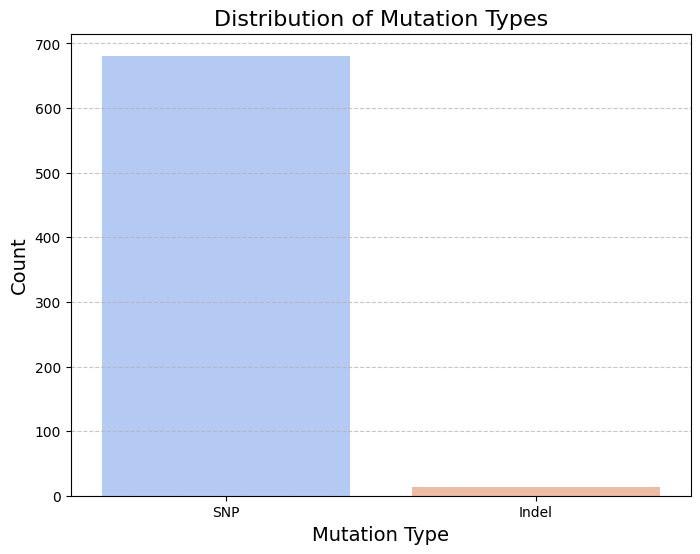

/tmp/ipykernel_174/3772919347.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ti_tv_counts.index, y=ti_tv_counts.values, palette="viridis")


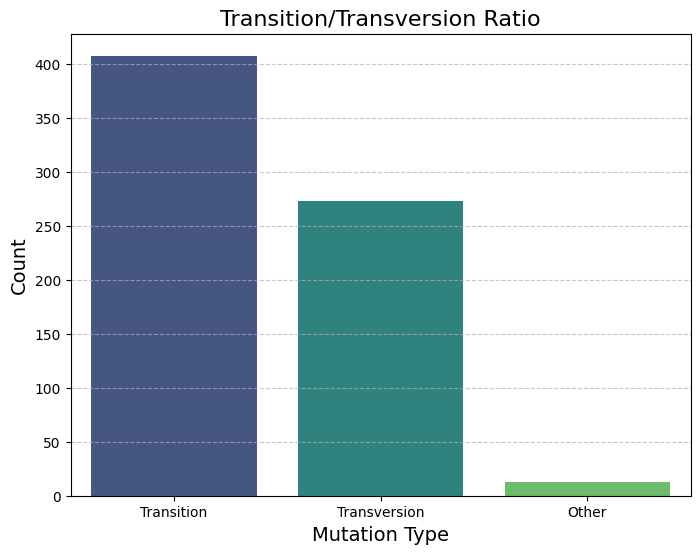

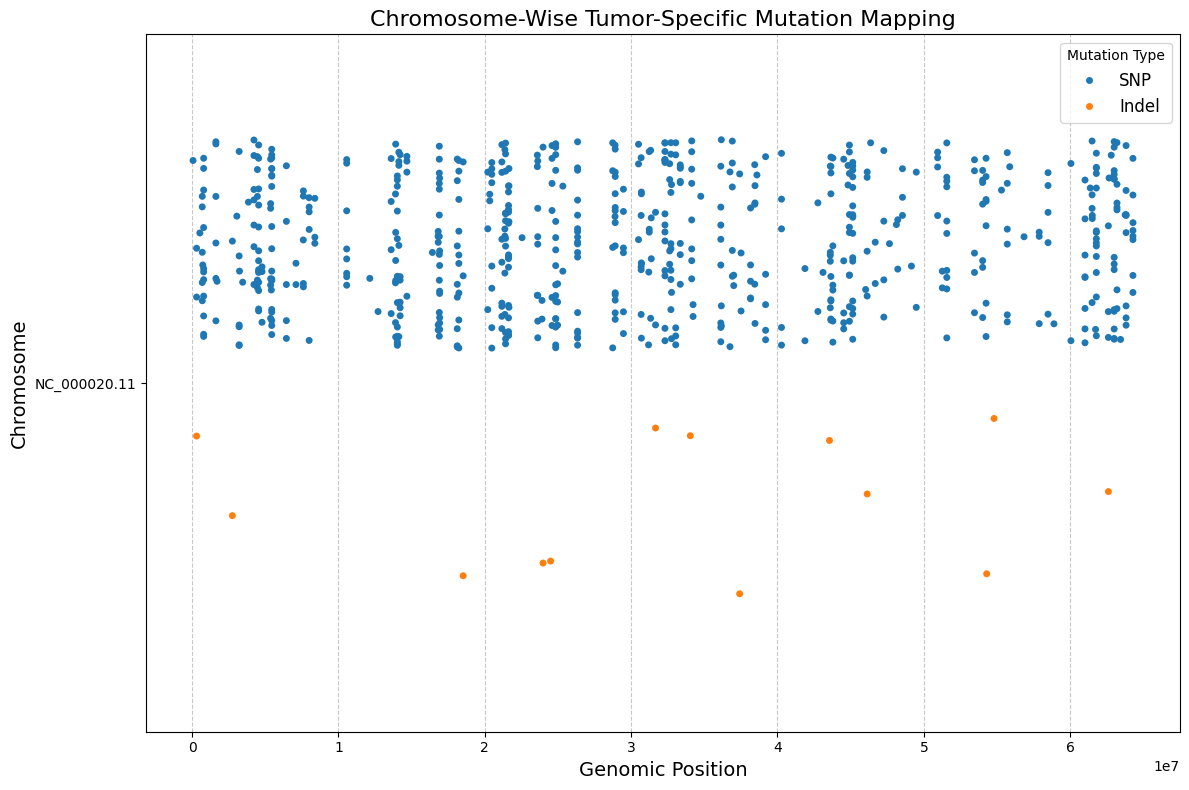

In [10]:
import pandas as pd
from pysam import VariantFile
import matplotlib.pyplot as plt
import seaborn as sns

# Input files
tumor_vcf_file = "tumor_calls.vcf"
normal_vcf_file = "norma_calls.vcf"

# Parse VCF file
def parse_vcf(vcf_file):
    vcf_in = VariantFile(vcf_file)
    mutations = []
    for record in vcf_in.fetch():
        chrom = record.chrom
        pos = record.pos
        ref = record.ref
        alt = ",".join(record.alts)
        qual = record.qual
        mutations.append((chrom, pos, ref, alt, qual))
    return pd.DataFrame(mutations, columns=["Chromosome", "Position", "Ref", "Alt", "Quality"])

# Identify tumor-specific mutations
def identify_tumor_specific(tumor_df, normal_df):
    merged = pd.merge(tumor_df, normal_df, how="left", on=["Chromosome", "Position", "Ref", "Alt"], indicator=True)
    tumor_specific = merged[merged["_merge"] == "left_only"].drop(columns=["_merge"])
    return tumor_specific

# Analyze mutation types
def classify_mutations(tumor_specific_df):
    def mutation_type(row):
        if len(row["Ref"]) == len(row["Alt"]) == 1:
            return "SNP"
        else:
            return "Indel"

    tumor_specific_df["Mutation_Type"] = tumor_specific_df.apply(mutation_type, axis=1)
    return tumor_specific_df

# Calculate transition/transversion ratio
def calculate_ti_tv_ratio(tumor_specific_df):
    transitions = {"A:G", "G:A", "C:T", "T:C"}
    transversions = {"A:C", "A:T", "C:A", "C:G", "G:C", "G:T", "T:A", "T:G"}

    def is_ti_tv(row):
        change = f"{row['Ref']}:{row['Alt']}"
        if change in transitions:
            return "Transition"
        elif change in transversions:
            return "Transversion"
        else:
            return "Other"

    tumor_specific_df["Ti_Tv"] = tumor_specific_df.apply(is_ti_tv, axis=1)
    ti_count = tumor_specific_df["Ti_Tv"].value_counts().get("Transition", 0)
    tv_count = tumor_specific_df["Ti_Tv"].value_counts().get("Transversion", 0)
    return ti_count, tv_count

# Fancy plots
def plot_fancy_visualizations(tumor_specific_df):
    # Mutation Type Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=tumor_specific_df, x="Mutation_Type", palette="coolwarm")
    plt.title("Distribution of Mutation Types", fontsize=16)
    plt.xlabel("Mutation Type", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Ti/Tv Ratio
    ti_tv_counts = tumor_specific_df["Ti_Tv"].value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=ti_tv_counts.index, y=ti_tv_counts.values, palette="viridis")
    plt.title("Transition/Transversion Ratio", fontsize=16)
    plt.xlabel("Mutation Type", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Chromosome-Wise Mutation Density
    plt.figure(figsize=(12, 8))
    sns.stripplot(
        data=tumor_specific_df,
        x="Position",
        y="Chromosome",
        hue="Mutation_Type",
        palette="tab10",
        jitter=0.3,
        dodge=True,
        size=5
    )
    plt.title("Chromosome-Wise Tumor-Specific Mutation Mapping", fontsize=16)
    plt.xlabel("Genomic Position", fontsize=14)
    plt.ylabel("Chromosome", fontsize=14)
    plt.legend(title="Mutation Type", fontsize=12, loc="upper right")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Main processing
tumor_df = parse_vcf(tumor_vcf_file)
normal_df = parse_vcf(normal_vcf_file)

# Identify tumor-specific mutations
tumor_specific_df = identify_tumor_specific(tumor_df, normal_df)

# Classify mutation types
tumor_specific_df = classify_mutations(tumor_specific_df)

# Calculate Ti/Tv Ratio
ti_count, tv_count = calculate_ti_tv_ratio(tumor_specific_df)
print(f"Transitions: {ti_count}, Transversions: {tv_count}, Ti/Tv Ratio: {ti_count / tv_count if tv_count > 0 else 'N/A'}")

# Fancy plots
plot_fancy_visualizations(tumor_specific_df)


/tmp/ipykernel_174/1331161744.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spectrum_counts.index, y=spectrum_counts.values, palette="mako")


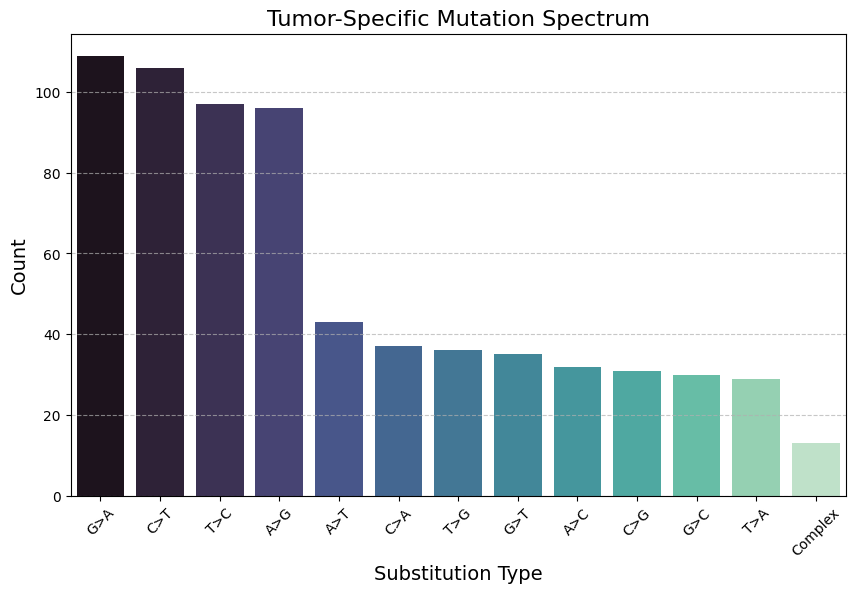

In [11]:
# Add mutation spectrum analysis
def mutation_spectrum(tumor_specific_df):
    def classify_substitution(row):
        ref, alt = row["Ref"], row["Alt"]
        if len(ref) == 1 and len(alt) == 1:
            return f"{ref}>{alt}"
        return "Complex"
    
    tumor_specific_df["Substitution"] = tumor_specific_df.apply(classify_substitution, axis=1)
    return tumor_specific_df

# Plot mutation spectrum
def plot_mutation_spectrum(tumor_specific_df):
    spectrum_counts = tumor_specific_df["Substitution"].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=spectrum_counts.index, y=spectrum_counts.values, palette="mako")
    plt.title("Tumor-Specific Mutation Spectrum", fontsize=16)
    plt.xlabel("Substitution Type", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Example functional impact plot
def plot_functional_impact(tumor_specific_df):
    functional_impact_counts = tumor_specific_df["Functional_Impact"].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=functional_impact_counts.index, y=functional_impact_counts.values, palette="viridis")
    plt.title("Functional Impact of Tumor-Specific Mutations", fontsize=16)
    plt.xlabel("Impact Type", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Run the new analyses
tumor_specific_df = mutation_spectrum(tumor_specific_df)
plot_mutation_spectrum(tumor_specific_df)

# If functional impact annotation is available, plot it
if "Functional_Impact" in tumor_specific_df.columns:
    plot_functional_impact(tumor_specific_df)


In [12]:

# Assuming normal_mutations_df is the DataFrame containing mutations from normal tissue
# Let's first calculate the mutation frequency in terms of reads per million (RPM)

# Function to calculate reads per million (RPM)
def calculate_rpm(mutations_df):
    total_mutations = len(mutations_df)  # Total mutations in the dataset
    mutation_counts = mutations_df['Alt'].value_counts()  # Count occurrences of each alt mutation
    
    # Calculate RPM for each mutation (alternative allele)
    rpm = (mutation_counts / total_mutations) * 1e6  # Convert to RPM (reads per million)
    return rpm

# Calculate the mutation frequency for normal tissue
normal_rpm = calculate_rpm(normal_mutations_df)

# Calculate the median background mutation level (RPM)
median_background_mutation_level = normal_rpm.median()

# Display the results
print("Median Background Mutation Level (RPM):", median_background_mutation_level)

# Now determine the threshold for confidently calling a mutation
# For simplicity, we'll assume a threshold of 5 times the median background mutation level
threshold_for_confident_call = 5 * median_background_mutation_level

print("\nThreshold for confidently calling a mutation (RPM):", threshold_for_confident_call)


Median Background Mutation Level (RPM): 232558.13953488372

Threshold for confidently calling a mutation (RPM): 1162790.6976744186
